<span>
<b>Author:</b> <a href="http://pages.di.unipi.it/ruggieri/">Salvatore Ruggieri</a><br/>
<b>Python version:</b>  3.x<br/>
</span>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# gloabl imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

# general settings  
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=12)
plt.rc('legend', fontsize=12)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

<AxesSubplot:>

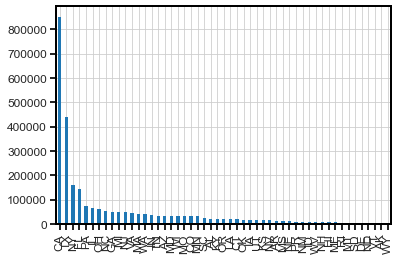

In [2]:
df = pd.read_pickle('df.pkl') 
orig_rac1p = df["RAC1P"].copy()

states = list(df['STATE'].unique())
wkhp = list(df['WKHP'].unique())
df["WKHP"].value_counts().plot(kind='bar')
df["STATE"].value_counts().plot(kind='bar')

<AxesSubplot:>

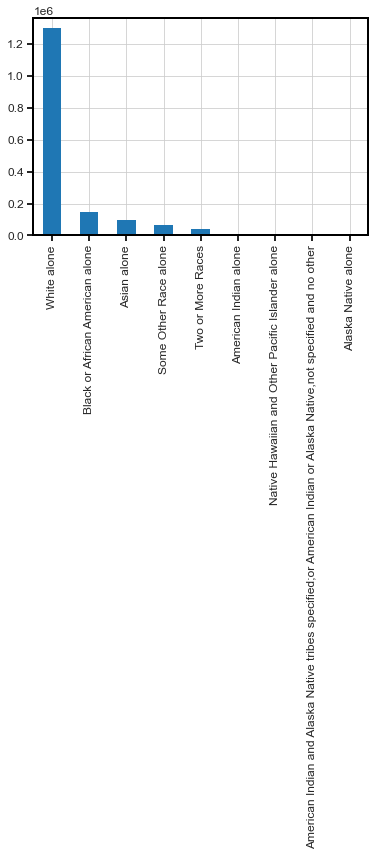

In [3]:
df["RAC1P"].value_counts().plot(kind='bar')

C:\Users\ruggieri\AppData\Local\Temp\ipykernel_17104\1301535455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RAC1P"][df["RAC1P"]!='White alone'] = 'Not White alone'


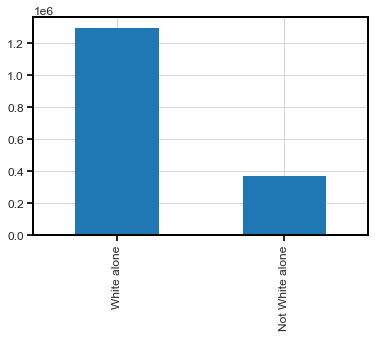

In [4]:
if True: # binarize RAC1P
    df["RAC1P"] = orig_rac1p
    df["RAC1P"][df["RAC1P"]!='White alone'] = 'Not White alone'
    df["RAC1P"].value_counts().plot(kind='bar')

In [5]:
# there are no missing values
df.isna().sum()

AGEP     0
COW      0
SCHL     0
MAR      0
OCCP     0
POBP     0
WKHP     0
SEX      0
RAC1P    0
STATE    0
class    0
dtype: int64

In [6]:
df

,AGEP,COW,SCHL,MAR,OCCP,POBP,WKHP,SEX,RAC1P,STATE,class
0,16-30,Employee of a private for-profit company orbus...,"Some college, but less than 1 year",Never married or under 15 years old,SAL,US,11-20,Female,Not White alone,AL,False
1,51-60,Federal government employee,GED or alternative credential,Never married or under 15 years old,HLS,US,31-40,Male,White alone,AL,False
2,31-40,Employee of a private for-profit company orbus...,Regular high school diploma,Never married or under 15 years old,RPR,US,31-40,Male,White alone,AL,False
3,16-30,Self-employed in own not incorporated business...,"Some college, but less than 1 year",Never married or under 15 years old,ENT,US,0-10,Female,White alone,AL,False
4,16-30,Federal government employee,"1 or more years of college credit, no degree",Never married or under 15 years old,PRT,US,>40,Male,White alone,AL,False
...,...,...,...,...,...,...,...,...,...,...,...
1664495,31-40,Self-employed in own not incorporated business...,Regular high school diploma,Never married or under 15 years old,CON,US,11-20,Male,White alone,PR,False
1664496,31-40,Self-employed in own not incorporated business...,Grade 11,Never married or under 15 years old,CLN,US,31-40,Male,Not White alone,PR,False
1664497,31-40,Employee of a private for-profit company orbus...,"1 or more years of college credit, no degree",Divorced,PRD,US,31-40,Female,Not White alone,PR,False
1664498,41-50,Employee of a private for-profit company orbus...,Regular high school diploma,Married,PRD,US,31-40,Male,Not White alone,PR,False


In [7]:
from sklearn.preprocessing import LabelEncoder

def encode(df):
    res = pd.DataFrame()
    encoders = dict()
    for col in df.columns:
        col_encoder = LabelEncoder()
        res[col] = col_encoder.fit_transform(df[col])
        res.loc[df[col].isnull(), col] = np.nan
        res[col] = res[col].astype('category')
        encoders[col] = col_encoder
    return (res, encoders)

In [8]:
# Encode categorical values
all_atts = ['STATE', 'RAC1P', 'WKHP', 'class']
adult = df[all_atts]
df, encoders = encode(adult)
df.head()

,STATE,RAC1P,WKHP,class
0,1.0,0.0,1.0,0.0
1,1.0,1.0,3.0,0.0
2,1.0,1.0,3.0,0.0
3,1.0,1.0,0.0,0.0
4,1.0,1.0,4.0,0.0


In [9]:
# 0 = negative, 1 = positive
encoders['class'].classes_

array([False,  True])

In [10]:
encoders['RAC1P'].classes_

array(['Not White alone', 'White alone'], dtype=object)

In [11]:
# split train test
X = df[df.columns.drop('class')]
y = df['class'].astype(int)
X_train, X_test, y_train, y_test, adult_train, adult_test = train_test_split(X, y, adult.copy(), test_size=0.33, random_state=42)

In [12]:
# training model and make predictions 
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
# add predicted class in the adult_test (decoding back)
y_pred_b = clf.predict(X_test)
adult_test['pred_b'] = encoders['class'].inverse_transform(y_pred_b)
# add predicted score in the adult_test
adult_test['score'] = clf.predict_proba(X_test)[:,1]
adult_test.head()

,STATE,RAC1P,WKHP,class,pred_b,score
517717,IL,White alone,>40,False,True,0.666491
319156,CT,Not White alone,31-40,False,False,0.376103
507501,IL,White alone,31-40,True,False,0.399454
537835,IL,White alone,>40,True,True,0.666491
305930,CT,White alone,31-40,True,True,0.528265


In [13]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import true_positive_rate

summary_b = MetricFrame(metrics=true_positive_rate,
                          y_true=y_test,
                          y_pred=y_pred_b,
                          sensitive_features=X_test['RAC1P'],
                          control_features=X_test['STATE'])
summary_b.overall, summary_b.by_group

Found 51 subgroups. Evaluation may be slow
Found 102 subgroups. Evaluation may be slow


(STATE
 0.0     0.691111
 1.0     0.372063
 2.0     0.422278
 3.0      0.37832
 4.0     0.362073
 5.0     0.464893
 6.0     0.846722
 7.0     0.387931
 8.0     0.389707
 9.0     0.370997
 10.0    0.474204
 11.0    0.504627
 12.0    0.429836
 13.0    0.450533
 14.0    0.477111
 15.0    0.451311
 16.0    0.451515
 17.0    0.371352
 18.0    0.841655
 19.0    0.732241
 20.0    0.458084
 21.0     0.47647
 22.0    0.447292
 23.0    0.441985
 24.0    0.349745
 25.0    0.462385
 26.0     0.40761
 27.0    0.441729
 28.0         0.0
 29.0     0.43814
 30.0    0.791842
 31.0    0.336471
 32.0    0.318981
 33.0    0.385362
 34.0    0.443551
 35.0    0.411198
 36.0    0.385075
 37.0    0.414874
 38.0         0.0
 39.0    0.403965
 40.0    0.398241
 41.0         0.0
 42.0    0.413691
 43.0    0.410305
 44.0    0.414951
 45.0    0.403303
 46.0    0.434889
 47.0    0.409379
 48.0    0.516094
 49.0     0.42743
 50.0    0.458564
 Name: true_positive_rate, dtype: object,
 STATE  RAC1P
 0.0    0.0        

In [14]:
# Fairlearn algorithms and utils (https://github.com/fairlearn/fairlearn)
# or try your preferred fair ML tool
from fairlearn.postprocessing import ThresholdOptimizer
# fairness by post-processing
postprocess_est = ThresholdOptimizer(estimator=clf, constraints="true_positive_rate_parity", prefit=True, predict_method='predict')
postprocess_est.fit(X_train, y_train, sensitive_features=X_train['RAC1P'])
# fair-corrected predictions 
y_pred_a = postprocess_est.predict(X_test, sensitive_features=X_test['RAC1P']).astype(int)
adult_test['pred_a'] = encoders['class'].inverse_transform(y_pred_a)

In [15]:
summary_a = MetricFrame(metrics=true_positive_rate,
                          y_true=y_test,
                          y_pred=y_pred_a,
                          sensitive_features=X_test['RAC1P'],
                          control_features=X_test['STATE'])
summary_a.overall, summary_a.by_group

Found 51 subgroups. Evaluation may be slow
Found 102 subgroups. Evaluation may be slow


(STATE
 0.0         0.26
 1.0     0.148825
 2.0     0.167914
 3.0     0.153659
 4.0     0.199258
 5.0     0.198179
 6.0     0.357326
 7.0     0.182759
 8.0     0.153086
 9.0      0.14736
 10.0    0.297475
 11.0    0.203593
 12.0    0.165613
 13.0    0.208305
 14.0    0.184248
 15.0    0.172285
 16.0    0.180952
 17.0    0.154019
 18.0    0.357584
 19.0    0.343934
 20.0     0.16018
 21.0    0.208753
 22.0    0.165654
 23.0    0.177363
 24.0    0.137521
 25.0     0.20367
 26.0    0.153426
 27.0    0.167293
 28.0         0.0
 29.0        0.16
 30.0    0.344296
 31.0    0.134118
 32.0    0.127956
 33.0    0.194063
 34.0    0.171933
 35.0    0.151716
 36.0    0.160821
 37.0     0.15855
 38.0         0.0
 39.0    0.199504
 40.0    0.152339
 41.0         0.0
 42.0    0.164945
 43.0    0.158902
 44.0    0.169014
 45.0    0.200536
 46.0    0.159705
 47.0     0.19323
 48.0    0.208277
 49.0    0.155792
 50.0    0.198895
 Name: true_positive_rate, dtype: object,
 STATE  RAC1P
 0.0    0.0        

In [27]:
xs = []
ys = []
descs = []
for s in range(51):
    for g in range(2):
        x = summary_b.overall[s] - summary_b.by_group[(s, g)]
        y = summary_a.overall[s] - summary_a.by_group[(s, g)]
        xs.append(x)
        ys.append(y)
        descs.append( (encoders['STATE'].classes_[s], encoders['RAC1P'].classes_[g]) )

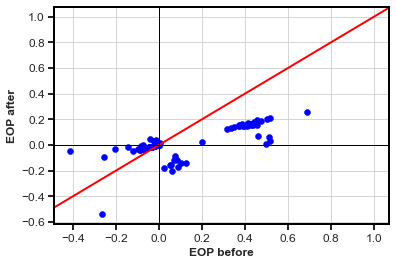

In [28]:
plt.scatter(xs, ys, c ="blue", linewidths = .5, marker ="o")
plt.xlabel("EOP before", fontweight="bold")
plt.ylabel("EOP after", fontweight="bold")
#plt.xlim([-1, 1])
#plt.ylim([-1, 1])
plt.axline((0, 0), (1, 1), linewidth=2, color='r')
plt.axline((0, 0), (0, 1), linewidth=1, color='black')
plt.axline((0, 0), (1, 0), linewidth=1, color='black')
plt.show()

In [34]:
from fairlearn.reductions import GridSearch

sweep = GridSearch(clf,TruePositiveRateParity(difference_bound=0.01), grid_size=31)
sweep.fit(X_train, y_train, sensitive_features=X_train['RAC1P'], control_features=X_train['STATE'])

D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pos_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.neg_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby

In [29]:
from fairlearn.reductions import TruePositiveRateParity

tprp = TruePositiveRateParity(difference_bound=0.01)
tprp.load_data(X_train, y_train, sensitive_features=X_train['RAC1P'], control_features=X_train['STATE'])

D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pos_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.neg_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

In [47]:
disparity = TruePositiveRateParity()
disparity.load_data(X_test, y_test, sensitive_features=X_test['RAC1P'], control_features=X_test['STATE'])

D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pos_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.neg_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

In [54]:
def classifier(X):
        return clf.predict(X)
d = disparity.gamma(classifier)
d = d['+']

In [61]:
d

event                group_id
control=0.0,label=1  0.0        -0.691111
                     1.0         0.254178
control=0.0,nan      0.0        -0.360700
                     1.0         0.344563
control=1.0,label=1  0.0        -0.372063
                                   ...   
control=8.0,nan      1.0         0.037572
control=9.0,label=1  0.0        -0.370997
                     1.0         0.118171
control=9.0,nan      0.0        -0.124306
                     1.0         0.069882
Length: 204, dtype: float64

In [38]:
from fairlearn.reductions import ErrorRate

predictors = sweep.predictors_
errors, disparities = [], []
for m in predictors:

    def classifier(X):
        return m.predict(X)

    error = ErrorRate()
    error.load_data(X_test, y_test, sensitive_features=X_test['RAC1P'], control_features=X_test['STATE'])
    disparity = TruePositiveRateParity()
    disparity.load_data(X_test, y_test, sensitive_features=X_test['RAC1P'], control_features=X_test['STATE'])

    errors.append(error.gamma(classifier)[0])
    disparities.append(disparity.gamma(classifier).max())

all_results = pd.DataFrame(
    {"predictor": predictors, "error": errors, "disparity": disparities}
)

non_dominated = []
for row in all_results.itertuples():
    errors_for_lower_or_eq_disparity = all_results["error"][
        all_results["disparity"] <= row.disparity
    ]
    if row.error <= errors_for_lower_or_eq_disparity.min():
        non_dominated.append(row.predictor)

D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pos_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.neg_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pos_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.neg_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pos_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.neg_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pos_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.neg_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pos_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.neg_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pos_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.neg_basis[i] = 0 + zero_vec
D:\FILES\Anaconda3\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

In [39]:
all_results

,predictor,error,disparity
0,LGBMClassifier(),0.318398,0.771362
1,LGBMClassifier(),0.309446,0.935084
2,LGBMClassifier(),0.309750,0.881676
3,LGBMClassifier(),0.328693,0.691111
4,LGBMClassifier(),0.307778,0.950761
5,LGBMClassifier(),0.319739,0.823659
6,LGBMClassifier(),0.318398,0.771362
7,LGBMClassifier(),0.313539,0.857613
8,LGBMClassifier(),0.310454,0.893792
9,LGBMClassifier(),0.311984,0.919089


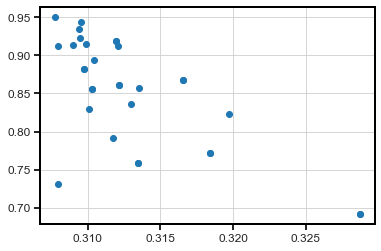

In [40]:
plt.scatter(all_results['error'], all_results['disparity'])
plt.show()

In [42]:
y_pred_c = all_results.iloc[12]['predictor'].predict(X_test).astype(int)
adult_test['pred_c'] = encoders['class'].inverse_transform(y_pred_c)

In [43]:
summary_c = MetricFrame(metrics=true_positive_rate,
                          y_true=y_test,
                          y_pred=y_pred_c,
                          sensitive_features=X_test['RAC1P'],
                          control_features=X_test['STATE'])

Found 51 subgroups. Evaluation may be slow
Found 102 subgroups. Evaluation may be slow


In [44]:
xs = []
ys = []
descs = []
for s in range(51):
    for g in range(2):
        x = summary_b.overall[s] - summary_b.by_group[(s, g)]
        y = summary_c.overall[s] - summary_c.by_group[(s, g)]
        xs.append(x)
        ys.append(y)
        descs.append( (encoders['STATE'].classes_[s], encoders['RAC1P'].classes_[g]) )

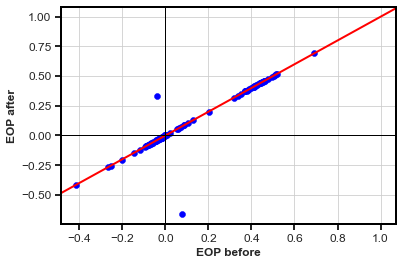

In [45]:
plt.scatter(xs, ys, c ="blue", linewidths = .5, marker ="o")
plt.xlabel("EOP before", fontweight="bold")
plt.ylabel("EOP after", fontweight="bold")
#plt.xlim([-1, 1])
#plt.ylim([-1, 1])
plt.axline((0, 0), (1, 1), linewidth=2, color='r')
plt.axline((0, 0), (0, 1), linewidth=1, color='black')
plt.axline((0, 0), (1, 0), linewidth=1, color='black')
plt.show()